# Deriving $f_{CDA}$ Using Z-Fit & Upstream XGB

In [125]:
import numpy as np
import tensorflow as tf
import zfit
from zfit import z
import pandas as pd
import uproot as up
import hist
from hist import Hist
import boost_histogram as bh
import matplotlib.pyplot as plt
import mplhep as hep
from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests import ConfidenceInterval
from hepstats.hypotests import UpperLimit
hep.style.use(hep.style.ROOT)

## Basic Gaussian Example

In [13]:
obs = zfit.Space('x', -10, 10) # Defines the name and domain of the observable
mu = zfit.Parameter("mu", 2.4, -1, 5) # Parameter name, default value, lower and upper limits
sigma = zfit.Parameter("sigma", 1.3, 0, 5)
yield_model = zfit.Parameter('yield_model', 5000, 1, 10000)

In [14]:
# gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma) # Define your PDF
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma, extended=yield_model)  # Extended i.e unnormalized

In [15]:
data_np = np.random.normal(0, 1, size=10000)
data = zfit.Data(data_np, obs=obs)

In [16]:
# Step 1: create an unbinned likelihood with the given PDF and data
#nll = zfit.loss.UnbinnedNLL(model=gauss, data=data)
nll = zfit.loss.ExtendedUnbinnedNLL(model=gauss, data=data)

# Step 2: instantiate a minimiser (in this case a basic minuit minimizer)
minimizer = zfit.minimize.Minuit()

# Step 3: minimise the given negative likelihood
result = minimizer.minimize(nll)

In [17]:
param_hesse = result.hesse()
print(param_hesse)

{<zfit.Parameter 'yield_model' floating=True value=9997>: {'error': 81.14646493138605, 'cl': 0.68268949}, <zfit.Parameter 'mu' floating=True value=0.002839>: {'error': 0.0099639237728642, 'cl': 0.68268949}, <zfit.Parameter 'sigma' floating=True value=0.9964>: {'error': 0.007045669493109619, 'cl': 0.68268949}}


In [18]:
# Check the fit cnverged and is valid
print(f"Function minimum: {result.fmin}")
print(f"Converged: {result.converged}")
print(f"Valid: {result.valid}")

Function minimum: -67949.93155138814
Converged: True
Valid: True


In [19]:
print(result.params)
print(result.params['mu']['value'])

name           value  (rounded)        hesse    at limit
-----------  ------------------  -----------  ----------
yield_model             9997.22  +/-      81       False
mu                   0.00283861  +/-    0.01       False
sigma                  0.996412  +/-   0.007       False
0.002838608646122287


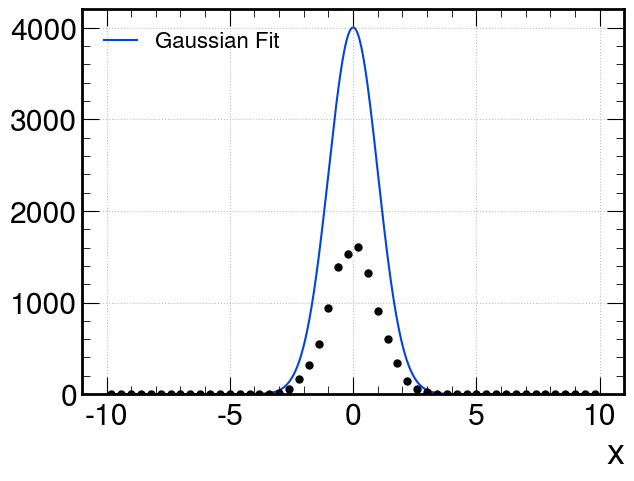

In [20]:
# plot the data as a histogramm
bins = 50
plt.figure(figsize=(7,5))
hep.histplot(data.to_binned(bins), yerr=True, density=False, color='black', histtype='errorbar')
# evaluate the func at multiple x and plot
x_plot = np.linspace(obs.v1.lower, obs.v1.upper, num=1000)
y_plot = gauss.ext_pdf(x_plot)
plt.plot(x_plot, y_plot, color='xkcd:blue', label="Gaussian Fit")
plt.legend(loc="upper left", fontsize=16)
plt.grid()
plt.show()

yield_model is just telling us the estimate for the total number of events in the dataset.

## Example: Binned Data

In [2]:
# Artifically bin the data
data_np = np.random.normal(2.1, 1.0, size=10000)

h = hist.Hist(hist.axis.Regular(bins=50, start=-8, stop=10, name="x"))
h.fill(x=data_np)
#hep.histplot(h)

Hist(Regular(50, -8, 10, name='x'), storage=Double()) # Sum: 10000.0

In [3]:
# Step 4: Convert binned data to zfit format
data = zfit.data.BinnedData.from_hist(h)

In [4]:
# Step 2: Define observables and parameters
obs2 = zfit.Space('x', -10, 10, binning=zfit.binned.RegularBinning(50, -8, 10, name="x"))
mu2 = zfit.Parameter("mu", 0.0, -10, 10)
sigma2 = zfit.Parameter("sigma", 1.0, 0.1, 5)

In [5]:
# Step 3: Create Gaussian model
gauss = zfit.pdf.Gauss(obs=obs2, mu=mu2, sigma=sigma2)
gauss_binned = zfit.pdf.BinnedFromUnbinnedPDF(pdf=gauss, space=obs2)

In [7]:
# Step 5: Define the binned negative log likelihood
nll = zfit.loss.BinnedNLL(model=gauss, data=data)

# Step 6: Instantiate a minimizer
minimizer = zfit.minimize.Minuit()

# Step 7: Minimize the negative log likelihood
result = minimizer.minimize(nll)

In [8]:
def print_result(result):
    print(f"Function minimum: {result.fmin}")
    print(f"Converged: {result.converged}")
    print(f"Valid: {result.valid}")

print_result(result)

Function minimum: -57760.900476458424
Converged: True
Valid: True


In [9]:
print(result.params)

name      value  (rounded)    at limit
------  ------------------  ----------
mu                 2.10573       False
sigma             0.988324       False


In [19]:
gauss_unbinned = zfit.pdf.UnbinnedFromBinnedPDF(gauss, obs=obs2)

In [26]:
obs_continuous = zfit.Space('x', -10, 10)
plot_gaus = zfit.pdf.Gauss(obs=obs_continuous, mu=mu2, sigma=sigma2)

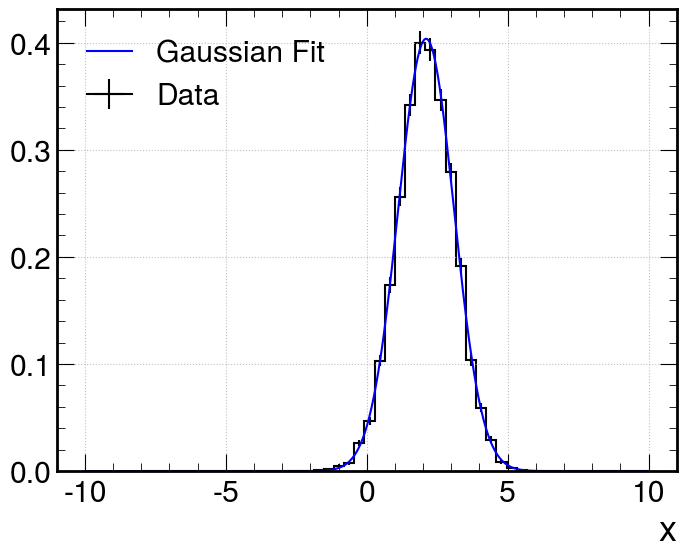

In [27]:
plt.figure(figsize=(8,6))
hep.histplot(h, label="Data", density=True, color="black")
x_plot = np.linspace(obs2.v1.lower, obs2.v1.upper, num=1000)
y_plot = plot_gaus.pdf(x_plot)
plt.plot(x_plot, y_plot, color="blue", label="Gaussian Fit")
plt.legend()
plt.grid()
plt.show()

## Custom Models with Binned Data

In [52]:
with up.open("./data/NewFW/2022_fCDASamples.root:PNNAnalysis") as f:
    h = f['sampleC_RelaxBB_CDA'].to_hist()
    hXGB = f['sampleCXGB_RelaxBB_CDA'].to_hist()

    htiming = f['sampleC_RelaxTime_CDA'].to_hist()
    htimingXGB = f['sampleCXGB_RelaxTime_CDA'].to_hist()

In [53]:
# Rebin all the histograms to 4 mm chunks
h = h[::bh.rebin(4)]
hXGB = hXGB[::bh.rebin(4)]

htiming = htiming[::bh.rebin(4)]
htimingXGB = htiming[::bh.rebin(4)]

In [9]:
class ThirdOrderPoly(zfit.pdf.ZPDF):
    """Third order polynomial a + (b * x) + (c * x^2) + (d * x^3)"""
    _PARAMS = ['a', 'b', 'c', 'd']

    @zfit.supports()
    def _unnormalized_pdf(self, x, params):
        data = x[0]
        a = params['a']
        b = params['b']
        c = params['c']
        d = params['d']

        return a + (b * data) + (c * data**2) + (d * data**3)

In [62]:
# Drop the [0,4] mm bin to prevent fitting issues
h = h[1:10]
h

Hist(Regular(9, 4, 40, name='xaxis'), storage=Double()) # Sum: 401.0 (408.0 with flow)

In [89]:
hXGB = hXGB[1:10]

In [63]:
data = zfit.data.BinnedData.from_hist(h)
obs = zfit.Space('xaxis', 4, 40, binning=zfit.binned.RegularBinning(9, 4, 40, name="xaxis"))

In [64]:
param_a = zfit.Parameter("a", 0, -20, 20)
param_b = zfit.Parameter("b", -1, -20, 20)
param_c = zfit.Parameter("c", 4, -20, 20)
param_d = zfit.Parameter("d", -2, -10, 0)

In [70]:
lam = zfit.Parameter("mu", -5, -50, 10)
gauss_tail = zfit.pdf.Exponential(obs=obs, lam=lam)

In [71]:
#three_poly = ThirdOrderPoly(obs=obs, a=param_a, b=param_b, c=param_c, d=param_d)
nll = zfit.loss.BinnedNLL(model=gauss_tail, data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)

print(f"Function minimum: {result.fmin}")
print(f"Converged: {result.converged}")
print(f"Valid: {result.valid}")

Function minimum: -1149.0296201557449
Converged: True
Valid: True


In [76]:
result.hesse()

{<zfit.Parameter 'mu' floating=True value=-0.03666>: {'error': 0.0050477193253823,
  'cl': 0.68268949}}

In [77]:
print(result.params)

name      value  (rounded)        hesse    at limit
------  ------------------  -----------  ----------
mu              -0.0366636  +/-   0.005       False


In [73]:
obs_continuous = zfit.Space('xaxis', 0, 40)
#smooth_three_poly = zfit.pdf.Exponential(obs=obs_continuous, a=param_a, b=param_b, c=param_c, d=param_d)
smooth_exp = zfit.pdf.Exponential(obs=obs_continuous, lam=lam)

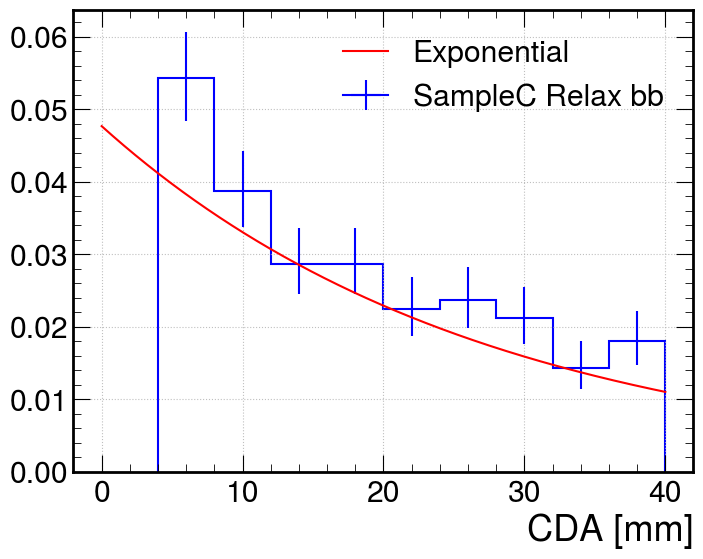

In [75]:
plt.figure(figsize=(8,6))
hep.histplot(h, color="blue", density=True, label="SampleC Relax bb")
x_plot = np.linspace(0, obs.v1.upper, num=1000)
y_plot = smooth_exp.pdf(x_plot)
plt.plot(x_plot, y_plot, color="red", label='Exponential')
plt.xlabel("CDA [mm]")
plt.legend()
plt.grid()
plt.show()

In [88]:
(smooth_exp.integrate((0,4)) / smooth_exp.integrate((4,40))).numpy()[0]

0.2155378539964464

In [93]:
calculator = AsymptoticCalculator(input=result, minimizer=minimizer)
value = result.params[lam]["value"]
error = result.params[lam]["hesse"]["error"]
mean_scan = POIarray(lam, np.linspace(value - 1.5 * error, value + 1.5 * error, 10))

ci = ConfidenceInterval(calculator, mean_scan)
ci.interval()

{'observed': -0.03666360870669294,
 'upper': -0.03164745156414617,
 'lower': -0.04172021980740632}

In [109]:
# Write it algorithimically
def exp_fit(histo, nbins, start, stop, minO=0, maxO=40, useChi2=False):
    data = zfit.data.BinnedData.from_hist(histo)
    obs = zfit.Space('xaxis', start, stop, binning=zfit.binned.RegularBinning(nbins, start, stop, name="xaxis"))
    lam = zfit.Parameter("mu", -5, -50, 10)
    model = zfit.pdf.Exponential(obs=obs, lam=lam)
    if not useChi2:
        nll = zfit.loss.BinnedNLL(model=model, data=data)
    else:
        nll = zfit.loss.BinnedChi2(model=model, data=data)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)

    print(f"Function minimum: {result.fmin}")
    print(f"Converged: {result.converged}")
    print(f"Valid: {result.valid}")

    result.hesse()

    print(result.params)

    obs_continuous = zfit.Space('xaxis', minO, maxO)
    smooth_exp = zfit.pdf.Exponential(obs=obs_continuous, lam=lam)

    return result, smooth_exp, model

In [110]:
result, smooth_model, model = exp_fit(hXGB, nbins=9, start=4, stop=40, useChi2=False)

Function minimum: -534.7654866953173
Converged: True
Valid: True
name      value  (rounded)        hesse    at limit
------  ------------------  -----------  ----------
mu              -0.0477718  +/-  0.0069       False


In [130]:
lam = result.params['mu']['value']
lamerr = result.params['mu']['hesse']['error']
lam, lamerr

(-0.04777183920415595, 0.0068898202374873705)

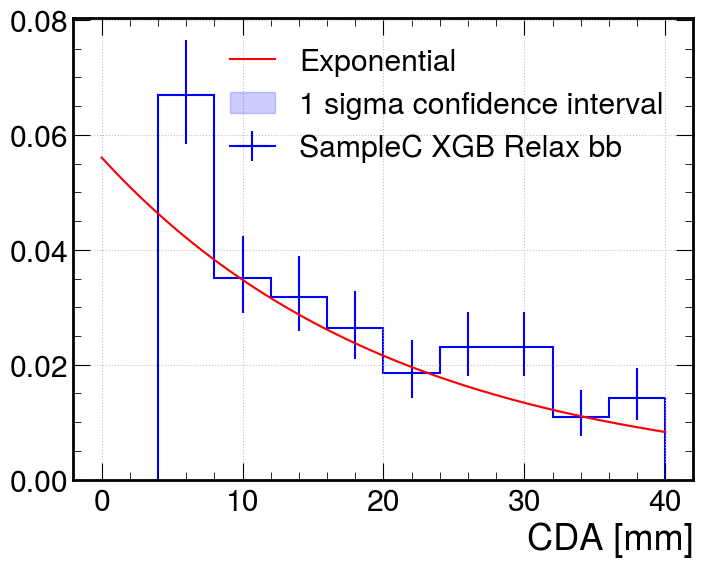

In [142]:
plt.figure(figsize=(8,6))
hep.histplot(hXGB, color="blue", density=True, label="SampleC XGB Relax bb")
x_plot = np.linspace(0, obs.v1.upper, num=1000)
y_plot = smooth_model.pdf(x_plot)
plt.plot(x_plot, y_plot, color="red", label='Exponential')
#plt.plot(x_plot, model.pdf(x_plot), color="green", label='Exponential Binned')

#upper_bound = np.exp(x_plot.flatten() * (lam - lamerr))
plt.fill_between(x_plot.flatten(), lower_bound, upper_bound, color='blue', alpha=0.2, label='1 sigma confidence interval')
plt.xlabel("CDA [mm]")
plt.legend()
plt.grid()
plt.show()

In [104]:
f_CDA_XGB = (smooth_model.integrate((0,4)) / smooth_model.integrate((4,40))).numpy()[0]
print(r"XGB: $f_{CDA}$ =", f_CDA_XGB)

XGB: $f_{CDA}$ = 0.25650668292805745


In [112]:
# Calculate the chi2 for goodness of fit
def chi2(obs, exp, nbins, nparams):
    chi2 = np.sum((obs - exp)**2 / exp)
    ndof = nbins - nparams
    return chi2 / ndof

In [123]:
chi2(smooth_model.pdf(hXGB.axes[0].centers), hXGB.values() / hXGB.values().sum(), 9, 1)

0.08049189222624364

In [127]:
result.params

{<zfit.Parameter 'mu' floating=True value=-0.04777>: {'value': -0.04777183920415595, 'hesse': {'error': 0.0068898202374873705, 'cl': 0.68268949}}}